<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_12_Weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

import sklearn.metrics as skm

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

##Create a Model and Inspect Weight Matrix Sizes

In [2]:
# Build a model
aModel = nn.Sequential(
    nn.Linear(10,14), # Input
    nn.Linear(14,19), # Hidden
    nn.Linear(19,8),  # Output
    )

aModel

Sequential(
  (0): Linear(in_features=10, out_features=14, bias=True)
  (1): Linear(in_features=14, out_features=19, bias=True)
  (2): Linear(in_features=19, out_features=8, bias=True)
)

In [3]:
# print the sizes of the weight matrices in each layer
for i in range(len(aModel)):
    print(aModel[i].weight.shape)

torch.Size([14, 10])
torch.Size([19, 14])
torch.Size([8, 19])


In [4]:
# Build a model with inconsitent layer shapes
# Build a model
M2 = nn.Sequential(
    nn.Linear(10,14), # Input
    nn.Linear(14,9), # Hidden
    nn.Linear(19,8),  # Output
    )

M2

Sequential(
  (0): Linear(in_features=10, out_features=14, bias=True)
  (1): Linear(in_features=14, out_features=9, bias=True)
  (2): Linear(in_features=19, out_features=8, bias=True)
)

In [5]:
# print the sizes of the weight matrices in each layer
for i in range(len(M2)):
    print(M2[i].weight.shape)

torch.Size([14, 10])
torch.Size([9, 14])
torch.Size([8, 19])


### Test both models with fake data

In [6]:
# generate the data
nsamples = 5
nfeatures = 10
fakedata = torch.randn(nsamples, nfeatures)
fakedata

tensor([[ 0.6199,  0.6673, -2.4932, -0.6809, -1.8391, -2.2743,  1.5807, -0.2682,
          0.9811, -0.0944],
        [ 0.5914,  1.0547, -0.4554, -0.5984,  1.4290, -0.6869,  0.4465, -0.6607,
         -0.7718, -1.4367],
        [ 0.0116, -1.6481,  1.1599,  1.8718, -1.9450, -2.3688, -0.1231, -0.2089,
          0.0686,  0.6698],
        [-0.8862,  1.7389,  1.3685,  0.2639,  0.4393, -0.4907, -1.3762, -0.0380,
          0.5977,  0.5818],
        [-0.6447, -0.9580, -1.7339,  0.4906,  0.9348, -1.2326,  0.0998,  1.9336,
          0.0405,  0.8372]])

In [7]:
# Test the first model
aModel(fakedata).shape

torch.Size([5, 8])

In [8]:
# Test the second model: It will fail!
# M2(fakedata).shape

## Demo on Weight Initialization

In [9]:
# Import the small MNIST dataset that comes with colab
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"),delimiter=",")

# Extract the labels and remove them from data
labels = data[:,0]
data = data[:,1:]

# Normalize data on range 0-1
dataNorm = data/np.max(data)

In [10]:
# COnvert the data into tensors
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Split
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1)

# Convert into Pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into dataLoader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [11]:
# Create the architecture class
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden Layers
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # Output Layer
            self.output = nn.Linear(32,10)

        # Forward Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            return self.output(x)

    # Create an instance
    net = mnistNet()

    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

In [12]:
# Check out the weights
tmpnet = createTheMNISTNet()[0]
print(tmpnet)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


In [13]:
print("Weights for Input Layer:")
print(tmpnet.input.weight.data)
print(tmpnet.input.weight.shape)

Weights for Input Layer:
tensor([[-0.0055,  0.0157, -0.0128,  ..., -0.0257,  0.0291, -0.0344],
        [-0.0182,  0.0356, -0.0337,  ...,  0.0214,  0.0049, -0.0286],
        [ 0.0087,  0.0131, -0.0028,  ..., -0.0254,  0.0295, -0.0323],
        ...,
        [-0.0038,  0.0044,  0.0299,  ..., -0.0322,  0.0127,  0.0013],
        [ 0.0291, -0.0292, -0.0121,  ..., -0.0105,  0.0278,  0.0340],
        [-0.0101, -0.0244, -0.0284,  ...,  0.0049, -0.0092, -0.0176]])
torch.Size([64, 784])


In [14]:
print("Weights for layer fc1:")
print(tmpnet.fc1.weight.data)
print(tmpnet.fc1.weight.shape)

Weights for layer fc1:
tensor([[-7.2452e-03,  8.4637e-02,  8.8091e-02,  ..., -2.5699e-02,
          1.1798e-01,  9.3043e-03],
        [-4.2302e-02,  1.1871e-01,  1.5691e-02,  ..., -6.8181e-02,
         -8.3151e-02, -9.9783e-02],
        [-8.8533e-02,  8.5148e-02, -4.1301e-02,  ..., -1.0712e-01,
         -6.3755e-02,  4.5664e-02],
        ...,
        [-5.0629e-02, -2.7721e-02,  3.0749e-03,  ..., -8.8178e-02,
          9.5884e-02, -1.1129e-01],
        [ 8.7060e-02, -1.1231e-02,  8.0672e-02,  ...,  7.7469e-02,
         -4.7170e-02, -5.4017e-05],
        [ 2.8518e-02,  5.8159e-02, -3.8255e-02,  ..., -2.8904e-02,
         -4.2358e-02,  8.1250e-02]])
torch.Size([32, 64])


In [15]:
# Create a function to train the model
def function2trainTheModel(net, lossfun, optimizer):

    numepochs = 10

    # Initialize the losses
    losses = torch.zeros((numepochs, 2))
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Switch the training mode on
        net.train()

        # Loop over the batches
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy of each batch
            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))

        # End of the batch loop 
        trainAcc.append(np.mean(batchAcc))
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad(): # deactivate autograd
            yHat = net(X)
        losses[epochi,1] = lossfun(yHat,y).item()
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
    
    # End of epochs
    return trainAcc, testAcc, losses, net

In [16]:
net_base, lossfun, optimizer = createTheMNISTNet()
trainAcc_base, testAcc_base, losses_base, net_base = function2trainTheModel(net_base, lossfun, optimizer)

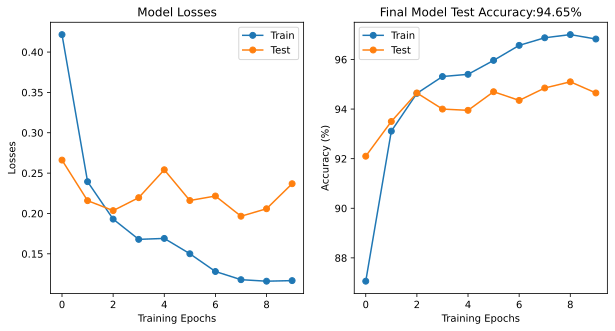

In [20]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(losses_base, "o-")
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Losses")
ax[0].set_title("Model Losses")
ax[0].legend(["Train", "Test"])

ax[1].plot(trainAcc_base,  "o-", label="Train")
ax[1].plot(testAcc_base,  "o-", label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final Model Test Accuracy:{testAcc_base[-1]:.2f}%")
ax[1].legend()

plt.show()

### Set all Weights of Layer 1 to Zero

In [21]:
# Change the weights before training
net_zero, lossfun, optimizer = createTheMNISTNet()

# set to zeros
net_zero.fc1.weight.data = torch.zeros_like(net_zero.fc1.weight)

# Confirm
net_zero.fc1.weight.data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [28]:
# Run the model and see what happens
trainAcc_zero, testAcc_zero, losses_zero, net_zero = function2trainTheModel(net_zero, lossfun, optimizer)

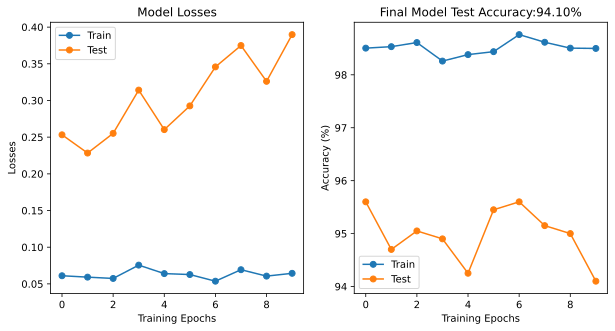

In [29]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(losses_zero, "o-")
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Losses")
ax[0].set_title("Model Losses")
ax[0].legend(["Train", "Test"])

ax[1].plot(trainAcc_zero,  "o-", label="Train")
ax[1].plot(testAcc_zero,  "o-", label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final Model Test Accuracy:{testAcc_zero[-1]:.2f}%")
ax[1].legend()

plt.show()

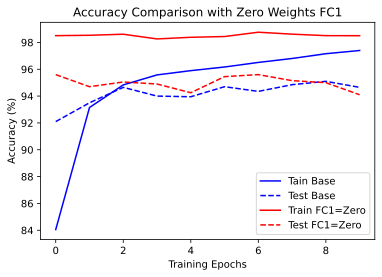

In [30]:
plt.plot(range(len(trainAcc_base)), trainAcc_base, "b-", range(len(testAcc_base)), testAcc_base, "b--")
plt.plot(range(len(trainAcc_zero)), trainAcc_zero, "r-", range(len(testAcc_zero)), testAcc_zero, "r--")
plt.legend(["Tain Base", "Test Base", "Train FC1=Zero", "Test FC1=Zero"])
plt.title("Accuracy Comparison with Zero Weights FC1")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy (%)")
plt.show()
# One layer as zero has no effect

In [31]:
# Check of all weights are still zero: Model has learned so they are not
print(net_zero.fc1.weight.data)

tensor([[-0.9244, -0.1457,  0.1001,  ..., -0.7638,  0.4404, -0.2512],
        [ 1.3904, -0.3959, -0.8109,  ..., -0.3107,  1.5671, -0.3963],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.2938, -0.0804,  0.4186,  ...,  0.4227, -0.5260,  0.9064],
        [-0.2115, -0.1783,  0.1456,  ...,  0.6119,  0.6804, -1.1759]])


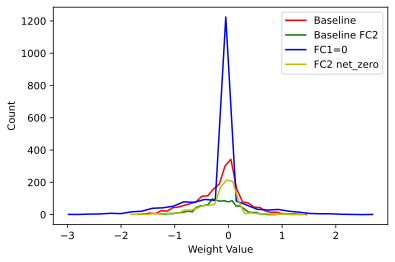

In [45]:
# Show a histogram of weight distribution
# Data for random value initiaization
y,x = np.histogram(net_base.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2, y, "r", label="Baseline")

y,x = np.histogram(net_base.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2, y, "g", label="Baseline FC2")

# Histogram for zero FC1 initialization
y,x = np.histogram(net_zero.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2, y, "b", label="FC1=0")

y,x = np.histogram(net_zero.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2, y, "y", label="FC2 net_zero")

plt.legend()
plt.xlabel("Weight Value")
plt.ylabel("Count")
plt.show()

# MOst of the weights of FC1 Zero are still near zero

### Set All Parameters to Zero

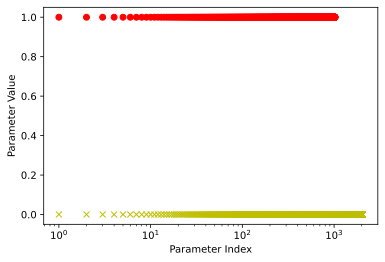

In [54]:
# Change the weights before training
net_allzero, lossfun, optimizer = createTheMNISTNet()

# Loop over the parameters and set them all to zero
for p in net_allzero.named_parameters():
    p[1].data = torch.zeros_like(p[1].data)

# Confirm by plotting
# plt.plot(0 + net_allzero.input.weight.data.flatten(), "bo") # too big
plt.plot(0 + net_allzero.fc1.weight.data.flatten(), "yx")
plt.plot(1 + net_allzero.fc2.weight.data.flatten(), "ro")
# plt.plot(3 + net_allzero.output.weight.data.flatten(), "g^") 

plt.xlabel("Parameter Index")
plt.ylabel("Parameter Value")
plt.xscale("log")
plt.show()

In [48]:
# Now train the model
trainAcc_allzero, testAcc_allzero, losses_allzero, net_allzero = function2trainTheModel(net_allzero, lossfun, optimizer)

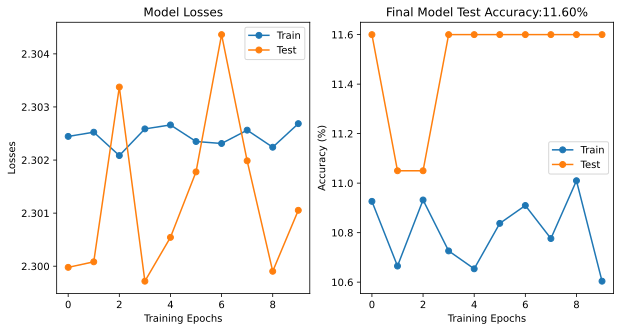

In [49]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(losses_allzero, "o-")
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Losses")
ax[0].set_title("Model Losses")
ax[0].legend(["Train", "Test"])

ax[1].plot(trainAcc_allzero,  "o-", label="Train")
ax[1].plot(testAcc_allzero,  "o-", label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final Model Test Accuracy:{testAcc_allzero[-1]:.2f}%")
ax[1].legend()

plt.show()

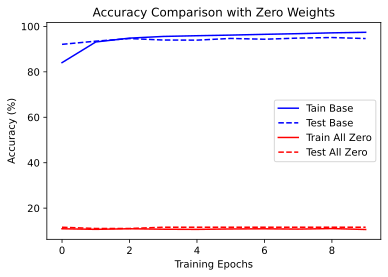

In [50]:
plt.plot(range(len(trainAcc_base)), trainAcc_base, "b-", range(len(testAcc_base)), testAcc_base, "b--")
plt.plot(range(len(trainAcc_allzero)), trainAcc_allzero, "r-", range(len(testAcc_allzero)), testAcc_allzero, "r--")
plt.legend(["Tain Base", "Test Base", "Train All Zero", "Test All Zero"])
plt.title("Accuracy Comparison with Zero Weights")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy (%)")
plt.show()

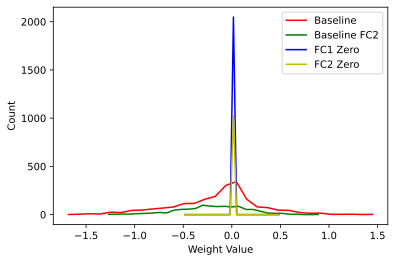

In [51]:
# Show a histogram of weight distribution
y,x = np.histogram(net_base.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2, y, "r", label="Baseline")

y,x = np.histogram(net_base.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2, y, "g", label="Baseline FC2")

# Histogram for zero FC1 initialization
y,x = np.histogram(net_allzero.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2, y, "b", label="FC1 Zero")

y,x = np.histogram(net_allzero.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2, y, "y", label="FC2 Zero")

plt.legend()
plt.xlabel("Weight Value")
plt.ylabel("Count")
plt.show()
# All the weights are zero: No learning

In [52]:
# No learning
print(net_allzero.fc1.weight.data)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


### Initialize All Values to 1

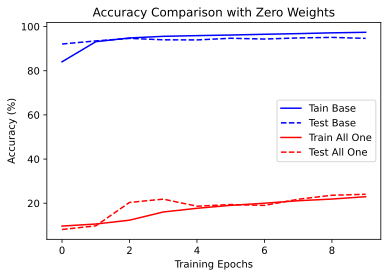

In [53]:
# Change the weights before training
net_allone, lossfun, optimizer = createTheMNISTNet()

# Loop over the parameters and set them all to zero
for p in net_allone.named_parameters():
    p[1].data = torch.zeros_like(p[1].data) + 1

# Now train the model
trainAcc_allone, testAcc_allone, losses_allone, net_allone = function2trainTheModel(net_allone, lossfun, optimizer)

plt.plot(range(len(trainAcc_base)), trainAcc_base, "b-", range(len(testAcc_base)), testAcc_base, "b--")
plt.plot(range(len(trainAcc_allone)), trainAcc_allone, "r-", range(len(testAcc_allone)), testAcc_allone, "r--")
plt.legend(["Tain Base", "Test Base", "Train All One", "Test All One"])
plt.title("Accuracy Comparison with Zero Weights")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy (%)")
plt.show()
# Better than all zero :)

## Weight Variance Initialization

Use the above code to initialize the weights to be Gaussian Random Numbers with standard deviations ranging from 0.0001 to 10 in 25 logarithmic steps. 

Build 25 models, run them 25 times and check the accuracy as function of standard deviations.

Create the histograms from all weights (accross all layers) with 80 bins per histogram

In [59]:
import time
# Define the range of standard deviations to be used: vector
stdevs = np.logspace(np.log10(0.0001), np.log10(10), 25)

# define the number of histogram bins for plotting the distribution
nHistBins = 80

# INitialize the results of the output matrix
accresults = np.zeros(len(stdevs))
histodata = np.zeros((len(stdevs), 2, nHistBins))

# Start the timer
startTime = time.process_time()

# Start the experiment
for idx, std in enumerate(stdevs):

    # Instantiate a fresh network
    net, lossfun, optimizer = createTheMNISTNet()

    # Set all the parameters according to each standard deviation
    # Normally distributed: change the standard deviation
    for p in net.named_parameters():
        p[1].data = torch.rand_like(p[1].data)*std

    # Train the Model
    trainAcc, testAcc, losses, net = function2trainTheModel(net, lossfun, optimizer)

    # Get accuracy by taking the mean of the last three results
    accresults[idx] = np.mean(testAcc[-3:])

    # Collect all parameters to single vector and compute the histogram
    tmpparams = np.array([])
    for p in net.named_parameters():
        tmpparams = np.concatenate((tmpparams, p[1].data.numpy().flatten()),axis=0)

    # Compute the histogram
    y,x = np.histogram(tmpparams, nHistBins)
    histodata[idx,0,:] = (x[1:]+x[:-1])/2
    histodata[idx,1,:] = y

    # time passed
    timeElapsed = time.process_time() - startTime
    print(f"Finished {idx+1}/{len(stdevs)} after {timeElapsed:3.0f}s. Model accuracy was {accresults[idx]:.3f}%")

Finished 1/25 after  22s. Model accuracy was 11.417%
Finished 2/25 after  42s. Model accuracy was 11.600%
Finished 3/25 after  61s. Model accuracy was 59.650%
Finished 4/25 after  79s. Model accuracy was 9.633%
Finished 5/25 after  95s. Model accuracy was 93.967%
Finished 6/25 after 115s. Model accuracy was 11.600%
Finished 7/25 after 137s. Model accuracy was 92.717%
Finished 8/25 after 159s. Model accuracy was 11.600%
Finished 9/25 after 179s. Model accuracy was 66.750%
Finished 10/25 after 199s. Model accuracy was 70.583%
Finished 11/25 after 216s. Model accuracy was 93.467%
Finished 12/25 after 231s. Model accuracy was 94.033%
Finished 13/25 after 247s. Model accuracy was 93.617%
Finished 14/25 after 268s. Model accuracy was 11.417%
Finished 15/25 after 288s. Model accuracy was 11.417%
Finished 16/25 after 308s. Model accuracy was 11.000%
Finished 17/25 after 325s. Model accuracy was 10.800%
Finished 18/25 after 341s. Model accuracy was 92.117%
Finished 19/25 after 355s. Model accur

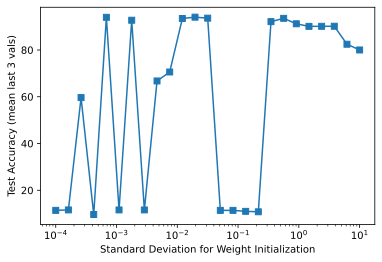

In [60]:
# Plot the results
plt.plot(stdevs, accresults, "s-")
plt.xlabel("Standard Deviation for Weight Initialization")
plt.ylabel("Test Accuracy (mean last 3 vals)")
plt.xscale("log")
plt.show()

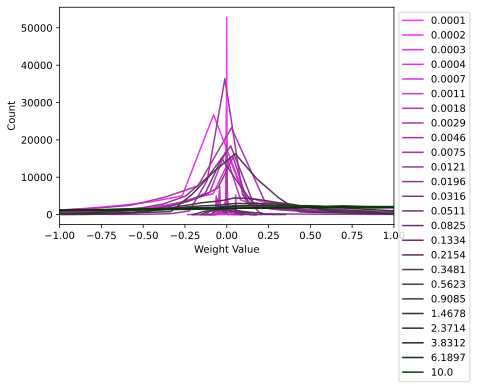

In [61]:
# Weight Distribution
for i in range(len(stdevs)):
    plt.plot(histodata[i,0,:], histodata[i,1,:], color=[1-i/len(stdevs), 0.2, 1-i/len(stdevs)])

plt.xlabel("Weight Value")
plt.ylabel("Count")
plt.legend(np.round(stdevs,4),bbox_to_anchor=(1,1), loc="upper left")
plt.xlim([-1,1])
plt.show()

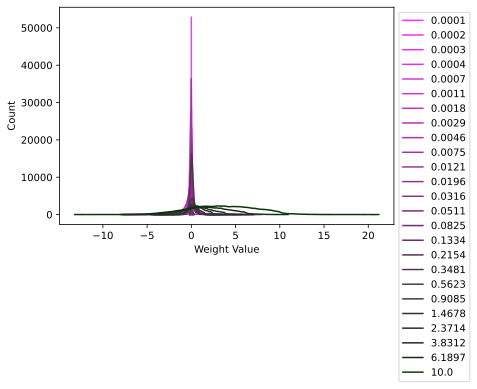

In [62]:
# Remove the limitation of x
for i in range(len(stdevs)):
    plt.plot(histodata[i,0,:], histodata[i,1,:], color=[1-i/len(stdevs), 0.2, 1-i/len(stdevs)])

plt.xlabel("Weight Value")
plt.ylabel("Count")
plt.legend(np.round(stdevs,4),bbox_to_anchor=(1,1), loc="upper left")
plt.show()